In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from app.wadray import Wad, Ray, _W, _R
from app.utils import *

YAML_SETUP = """
module: app.prototype
risk_modules:
  - name: Roulette
    mcr_percentage: 100
    premium_share: 0
    ensuro_share: 0
etokens:
  - name: eUSD1WEEK
    expiration_period: 604800
  - name: eUSD1MONTH
    expiration_period: 2592000
  - name: eUSD1YEAR
    expiration_period: 31536000
"""

# protocol = load_config(StringIO(YAML_SETUP))

In [2]:
policy_count = 0

def policy_factory(protocol, *args, **kwargs):
    global policy_count
    policy_count += 1
    return protocol.new_policy(
        "Roulette", payout=_W(360), premium=_W(10), 
        loss_prob=_R(1/37), expiration=protocol.now() + 10 * DAY,
    )


def policy_resolver(policy_id, protocol, today, **kwargs):
    policy = protocol.policies.get(policy_id)
    if policy.expiration > today:
        return None
    return random.random() <= (1/37)


class MyObserver(SimulationObserver):
    metrics = ["total_supply", "profit", "mcr", "ocean"]

    def start(self, protocol, **kwargs):
        super().start(protocol=protocol, **kwargs)
        print("LP1 deposits 1M, balance: {}".format(protocol.deposit("eUSD1YEAR", "LP1", _W(1000000))))
        self.token = protocol.etokens["eUSD1YEAR"]
        self.initial_supply = self.token.total_supply()

    def get_mcr(self, protocol, **kwargs):
        return self.token.mcr.to_float()

    def get_total_supply(self, protocol, **kwargs):
        return self.token.total_supply().to_float()

    def get_ocean(self, protocol, **kwargs):
        return self.token.ocean.to_float()

    def get_profit(self, protocol, **kwargs):
        return (self.token.total_supply() - self.initial_supply).to_float()


policy_distribution = list(random_distribute(10000, 365))

observer = MyObserver()

for run in range(10):
    protocol = load_config(StringIO(YAML_SETUP))    
    run_simulation(
        protocol, DAY, policy_distribution,
        policy_factory, policy_resolver, observer
    )

LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000


In [3]:
policy_count

100000

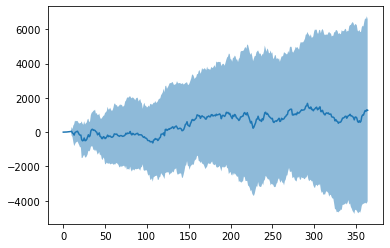

In [4]:
fig, ax = plt.subplots()
profit_mean = observer.mean("profit")
profit_std = observer.std("profit")

ax.plot(range(365), profit_mean, '-')
ax.fill_between(range(365), profit_mean - profit_std, profit_mean + profit_std, alpha=0.5)
